Задача 1. Оцінювання дефолту клієнта за допомогою скорингової моделі на основі дерев рішень 
1. Для набору навчальних даних з файлу Data_Base_I.xls розбити вхідну вибірку на навчальну та тестову (для перевірки якості моделі використати не менше 10% вхідної вибірки).
2. Застосувати щонайменше 2 різних алгоритми побудови дерев рішень, побудувати дерева рішень та визначити ймовірність події – дефолту клієнта.
3. Виконати перевірку якості моделей за допомогою тестової вибірки.
4. Обчислити загальну похибку моделей (CA – common accuracy) та похибки класифікації –1-го, 2-го роду на навчальній та тестовій вибірці.
5. Побудувати скорингові моделі у вигляді дерева рішень, використовуючи різні значення порогу. При класифікації розгляньте випадки 95%, 90%, 85 та 80%.
6. Занести результати моделювання з різними порогами та різними алгоритмами побудови у порівняльну таблицю.
7. Оформити протокол у вигляді порівняння обох методів, структур дерев та зробити висновки.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [2]:
df = pd.read_csv('DataBase.csv')

df.head()

Gender  Age  Сredit_sum Currency  Term_of_crediting_in day  \
0  Female   27         850      UAH                       360   
1    Male   35         400      USD                       240   
2    Male   43        2750      UAH                       240   
3    Male   43       15000      USD                      1800   
4    Male   28        2500      UAH                      1080   

   Interest rate_% Duration_of_stay_in_a_sity  Maritial_status Children  \
0               18                       24_60          SINGLE       c0   
1               12                       24_60          SINGLE       c0   
2               14                       24_60         MARRIED       c1   
3               15                      60_120         MARRIED       c1   
4               18                      60_120          SINGLE       c0   

  Job_position Tenure_with_current_employer Term_of_existence_of_enterprise  \
0           PE                        24_60                           24_60   
1           AS                        24_60                           24_60   
2           AS                        12_18                           12_24   
3           TM                        24_60                           24_60   
4           PE                          0_3                            0_12   

  Company_type Number_of_employees_in_kompany   Income_customer  \
0           FS                        100_9999              674   
1          FMG                          51_100              690   
2           OT                           31_50             1588   
3           OT                             0_5             4869   
4           FS                        100_9999              637   

   Costs_customer      goal_credit Result  
0             362  consumer_credit   good  
1             342  consumer_credit    bad  
2             767  consumer_credit   good  
3             800  consumer_credit    bad  
4             382  consumer_credit   good

In [3]:
df.isnull().sum().sum()

0

There are no missing values in this dataset

In [4]:
df.apply(lambda x: x.unique())

Gender                                                                [Female, Male]
Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Сredit_sum                         [850, 400, 2750, 15000, 2500, 2215, 54600, 200...
Currency                                              [UAH, USD, EUR, 0,  USD,  UAH]
Term_of_crediting_in day           [360, 240, 1800, 1080, 90, 2520, 60, 720, 1080...
Interest rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_sity          [24_60, 60_120, 120_9999, 12_24, 6_12, 3_6, 0_3]
Maritial_status                           [SINGLE, MARRIED, DIVORCED, CIVILMARRIAGE]
Children                                                            [c0, c1, c2, c3]
Job_position                                                    [PE, AS, TM, SP, MM]
Tenure_with_current_employer       [24_60, 12_18, 0_3, 60_120, 120_9999, 3_6, 18_...
Term_of_existence_of_enterprise               [24_60, 12_24, 0_12

In [5]:
df.columns = df.columns.str.strip()

df.rename(columns={'Term_of_crediting_in day': 'Term_of_crediting_in_days',
                   'Interest rate_%': 'Interest_rate_%',
                   'Duration_of_stay_in_a_sity': 'Duration_of_stay_in_a_city',
                   'Number_of_employees_in_kompany': 'Number_of_employees_in_company',
                   'goal_credit': 'Goal_credit'}, inplace=True)


In [6]:
df.apply(lambda x: x.unique())

Gender                                                                [Female, Male]
Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Сredit_sum                         [850, 400, 2750, 15000, 2500, 2215, 54600, 200...
Currency                                              [UAH, USD, EUR, 0,  USD,  UAH]
Term_of_crediting_in_days          [360, 240, 1800, 1080, 90, 2520, 60, 720, 1080...
Interest_rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_city          [24_60, 60_120, 120_9999, 12_24, 6_12, 3_6, 0_3]
Maritial_status                           [SINGLE, MARRIED, DIVORCED, CIVILMARRIAGE]
Children                                                            [c0, c1, c2, c3]
Job_position                                                    [PE, AS, TM, SP, MM]
Tenure_with_current_employer       [24_60, 12_18, 0_3, 60_120, 120_9999, 3_6, 18_...
Term_of_existence_of_enterprise               [24_60, 12_24, 0_12

### Gender

In [7]:
df['Gender'].value_counts()

Gender
Male      8136
Female    6864
Name: count, dtype: int64

In [8]:
df = pd.get_dummies(df, columns=['Gender'])

In [9]:
df[['Gender_Female', 'Gender_Male']].head()

Gender_Female  Gender_Male
0           True        False
1          False         True
2          False         True
3          False         True
4          False         True

### Age

<Axes: title={'center': 'Age Distribution'}, ylabel='Frequency'>

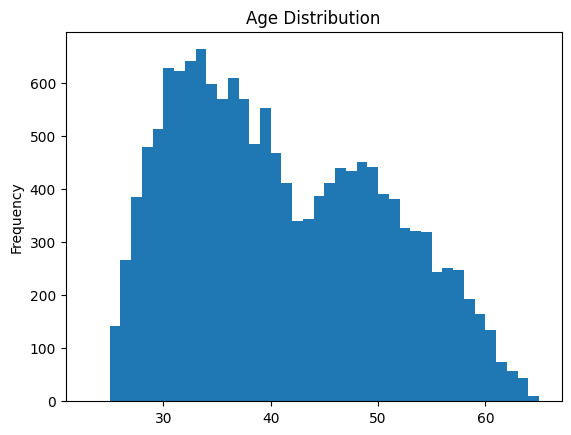

In [10]:
num_bins = len(df['Age'].unique())
df['Age'].plot(kind='hist', bins=num_bins, title='Age Distribution')

In [11]:
df['Age'].describe()

count    15000.000000
mean        40.587867
std          9.460069
min         23.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         65.000000
Name: Age, dtype: float64

### Credit Sum

<Axes: title={'center': 'Credit Sum Distibution'}, ylabel='Frequency'>

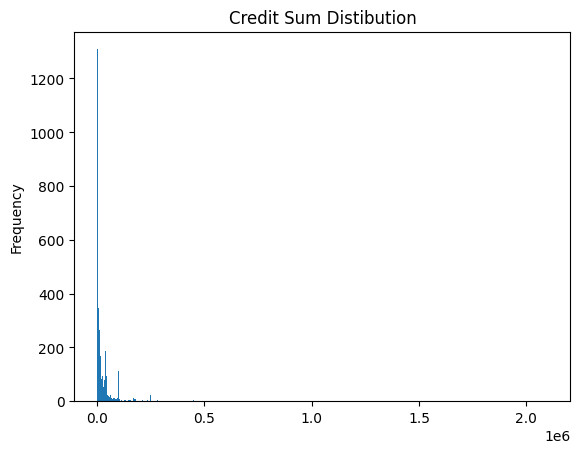

In [12]:
num_bins = len(df['Сredit_sum'].unique())
df['Сredit_sum'].plot(kind='hist', bins=num_bins, title='Credit Sum Distibution')

### Currency

In [13]:
df['Currency'] = df['Currency'].str.strip()
df['Currency'].replace('0', np.nan, inplace=True)

/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_68023/379763580.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Currency'].replace('0', np.nan, inplace=True)


In [14]:
print(df['Currency'].unique())
df.loc[df['Currency'].isnull()]

['UAH' 'USD' 'EUR' nan]


Age  Сredit_sum Currency  Term_of_crediting_in_days  Interest_rate_%  \
5251    44        2619      NaN                        360               28   
14249   40       96000      NaN                       5400               13   

      Duration_of_stay_in_a_city Maritial_status Children Job_position  \
5251                    120_9999         MARRIED       c2           AS   
14249                       6_12         MARRIED       c1           AS   

      Tenure_with_current_employer Term_of_existence_of_enterprise  \
5251                      120_9999                        120_9999   
14249                        24_60                           24_60   

      Company_type Number_of_employees_in_company  Income_customer  \
5251            OT                       100_9999             1138   
14249           WB                            0_5             8397   

       Costs_customer      Goal_credit Result  Gender_Female  Gender_Male  
5251              155  consumer_credit   good           True        False  
14249               0             flat   good           True        False

In [15]:
df.dropna(subset=['Currency'], inplace=True)
df['Currency'].unique()

array(['UAH', 'USD', 'EUR'], dtype=object)

Lets add the column named location

In [16]:
df['Location'] = df['Currency'].map({'USD': 'USA', 'UAH': 'UA', 'EUR': 'EU'})

df[['Currency', 'Location']].head()

Currency Location
0      UAH       UA
1      USD      USA
2      UAH       UA
3      USD      USA
4      UAH       UA

Convert everything to hryvnas, so we wont confuse the model

In [17]:
exchange_rates = {
    'UAH': 1,   
    'USD': 41,  
    'EUR': 46   
}

df['Credit_sum_in_UAH'] = df['Сredit_sum'] * df['Currency'].map(exchange_rates)
df['Income_in_UAH'] = df['Income_customer'] * df['Currency'].map(exchange_rates)
df['Costs_in_UAH'] = df['Costs_customer'] * df['Currency'].map(exchange_rates)

df[['Сredit_sum', 'Income_customer', 'Costs_customer', 'Currency', 'Credit_sum_in_UAH', 'Income_in_UAH', 'Costs_in_UAH']].head()

Сredit_sum  Income_customer  Costs_customer Currency  Credit_sum_in_UAH  \
0         850              674             362      UAH                850   
1         400              690             342      USD              16400   
2        2750             1588             767      UAH               2750   
3       15000             4869             800      USD             615000   
4        2500              637             382      UAH               2500   

   Income_in_UAH  Costs_in_UAH  
0            674           362  
1          28290         14022  
2           1588           767  
3         199629         32800  
4            637           382

In [18]:
df.drop(columns=['Сredit_sum', 'Income_customer', 'Costs_customer', 'Currency'], inplace=True)

### Term of crediting in day
as the interest rate is in year percentage, I think it would be better to convert days in years 

In [19]:
df['Term_of_crediting_in_days'].min(), df['Term_of_crediting_in_days'].max()

(30, 109685055)

There are some outliers, so I will drop all of the rows where credit is given for more then 30 years

In [20]:
df = df[df['Term_of_crediting_in_days'] <= 10980]

df[['Term_of_crediting_in_days']].describe()

Term_of_crediting_in_days
count               14986.000000
mean                 2015.654611
std                  1627.773822
min                    30.000000
25%                   720.000000
50%                  1800.000000
75%                  2520.000000
max                 10800.000000

In [21]:
df['Term_of_crediting_in_years'] = df['Term_of_crediting_in_days']/365
df.drop(columns=['Term_of_crediting_in_days'], inplace=True)

df[['Term_of_crediting_in_years']].head()

Term_of_crediting_in_years
0                    0.986301
1                    0.657534
2                    0.657534
3                    4.931507
4                    2.958904

In [22]:
df['Term_of_crediting_in_years'].min(), df['Term_of_crediting_in_years'].max()

(0.0821917808219178, 29.589041095890412)

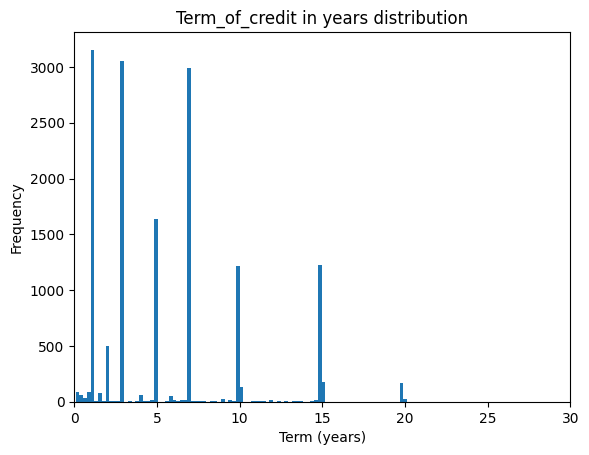

In [23]:
num_bins = len(df['Term_of_crediting_in_years'].unique())
plt.hist(df['Term_of_crediting_in_years'], bins=num_bins)

plt.xlim(0, 30)

plt.title('Term_of_credit in years distribution')
plt.xlabel('Term (years)')
plt.ylabel('Frequency')
plt.show()

In [24]:
df['Total_repayment'] = df['Credit_sum_in_UAH'] * (1 + (df['Interest_rate_%'] / 100) * df['Term_of_crediting_in_years'])
pd.options.display.float_format = '{:,.2f}'.format
df[['Credit_sum_in_UAH', 'Interest_rate_%', 'Term_of_crediting_in_years', 'Total_repayment']].head()

Credit_sum_in_UAH  Interest_rate_%  Term_of_crediting_in_years  \
0                850               18                        0.99   
1              16400               12                        0.66   
2               2750               14                        0.66   
3             615000               15                        4.93   
4               2500               18                        2.96   

   Total_repayment  
0         1,000.90  
1        17,694.03  
2         3,003.15  
3     1,069,931.51  
4         3,831.51

In [25]:
bins = [0, 1, 5, 30]
labels = ['Short-Term', 'Medium-Term', 'Long-Term']  
df['Loan_Term_Category'] = pd.cut(df['Term_of_crediting_in_years'], bins=bins, labels=labels, right=False)
df[['Term_of_crediting_in_years', 'Loan_Term_Category']].head()


Term_of_crediting_in_years Loan_Term_Category
0                        0.99         Short-Term
1                        0.66         Short-Term
2                        0.66         Short-Term
3                        4.93        Medium-Term
4                        2.96        Medium-Term

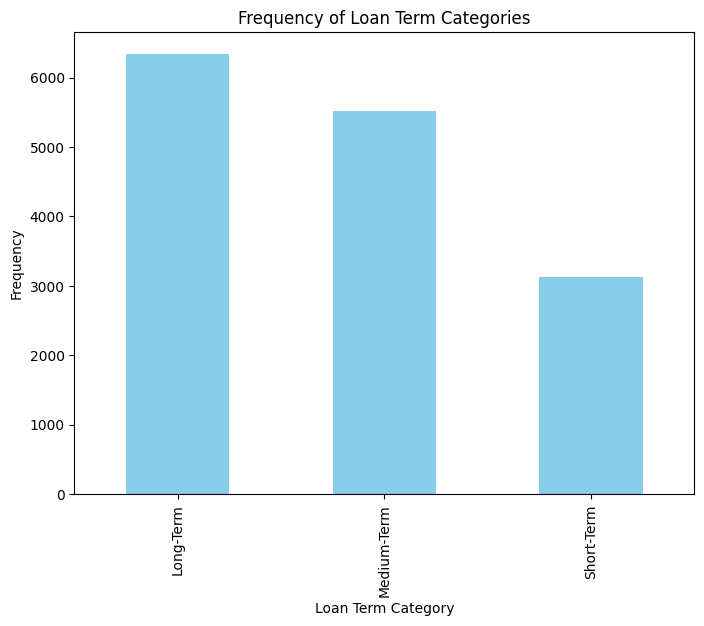

In [26]:
category_counts = df['Loan_Term_Category'].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')

plt.title('Frequency of Loan Term Categories')
plt.xlabel('Loan Term Category')
plt.ylabel('Frequency')
plt.show()

In [27]:
df['Interest_rate_%'].min(), df['Interest_rate_%'].max()

(0, 30)

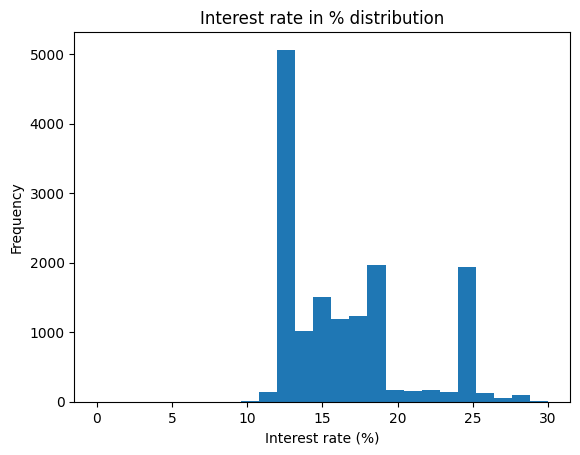

In [28]:
num_bins = len(df['Interest_rate_%'].unique())

df['Interest_rate_%'].plot(kind='hist', bins=num_bins, title='Interest rate in % distribution')
plt.xlabel('Interest rate (%)')
plt.ylabel('Frequency')
plt.show()

In [29]:
df = pd.get_dummies(df, columns=['Maritial_status', 'Job_position'], drop_first=True)
df = pd.get_dummies(df, columns=['Location'])

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Number_of_employees_in_company'] = le.fit_transform(df['Number_of_employees_in_company'])

In [31]:
df['Children'] = df['Children'].replace({'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3})

/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_68023/2645860986.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Children'] = df['Children'].replace({'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3})


In [32]:
print(df['Duration_of_stay_in_a_city'].unique())
print(df['Tenure_with_current_employer'].unique())
print(df['Term_of_existence_of_enterprise'].unique())
print(df['Company_type'].unique())
print(df['Goal_credit'].unique())

['24_60' '60_120' '120_9999' '12_24' '6_12' '3_6' '0_3']
['24_60' '12_18' '0_3' '60_120' '120_9999' '3_6' '18_24' '6_12']
['24_60' '12_24' '0_12' '120_9999' '60_120']
['FS' 'FMG' 'OT' 'WB' 'EC' 'HI' 'MPP' 'ASTL' 'EOG' 'ITT' 'FMCG' 'AP' 'RE'
 'MFC' 'ALC' 'PSL' 'CA' 'LI' 'AG' 'TSPW' 'ESB' 'CI' 'HRC']
['consumer_credit' 'flat' 'house' 'overhaul' 'auto' 'consumer_credit ']


Choosing middle value instead of range, so column is a number

In [33]:
duration_mapping = {'24_60': 42, '60_120': 90, '120_9999': 1000, '12_24': 18, 
                    '6_12': 9, '3_6': 4.5, '0_3': 1.5}
df['Duration_of_stay_in_a_city'] = df['Duration_of_stay_in_a_city'].replace(duration_mapping)

tenure_mapping = {'24_60': 42, '12_18': 15, '0_3': 1.5, '60_120': 90, '120_9999': 1000, 
                  '3_6': 4.5, '18_24': 21, '6_12': 9}
df['Tenure_with_current_employer'] = df['Tenure_with_current_employer'].replace(tenure_mapping)

existence_mapping = {'24_60': 42, '12_24': 18, '0_12': 6, '120_9999': 1000, '60_120': 90}
df['Term_of_existence_of_enterprise'] = df['Term_of_existence_of_enterprise'].replace(existence_mapping)

df[['Duration_of_stay_in_a_city', 'Tenure_with_current_employer', 'Term_of_existence_of_enterprise']].head()


/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_68023/4055239683.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Duration_of_stay_in_a_city'] = df['Duration_of_stay_in_a_city'].replace(duration_mapping)
/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_68023/4055239683.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Tenure_with_current_employer'] = df['Tenure_with_current_employer'].replace(tenure_mapping)
/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_68023/4055239683.py:10: FutureW

Duration_of_stay_in_a_city  Tenure_with_current_employer  \
0                       42.00                         42.00   
1                       42.00                         42.00   
2                       42.00                         15.00   
3                       90.00                         42.00   
4                       90.00                          1.50   

   Term_of_existence_of_enterprise  
0                               42  
1                               42  
2                               18  
3                               42  
4                                6

In [34]:
df['Goal_credit'] = df['Goal_credit'].str.strip()
df = pd.get_dummies(df, columns=['Company_type', 'Goal_credit'])

df.head()

Age  Interest_rate_%  Duration_of_stay_in_a_city  Children  \
0   27               18                       42.00         0   
1   35               12                       42.00         0   
2   43               14                       42.00         1   
3   43               15                       90.00         1   
4   28               18                       90.00         0   

   Tenure_with_current_employer  Term_of_existence_of_enterprise  \
0                         42.00                               42   
1                         42.00                               42   
2                         15.00                               18   
3                         42.00                               42   
4                          1.50                                6   

   Number_of_employees_in_company Result  Gender_Female  Gender_Male  ...  \
0                               1   good           True        False  ...   
1                               3    bad          False         True  ...   
2                               2   good          False         True  ...   
3                               0    bad          False         True  ...   
4                               1   good          False         True  ...   

   Company_type_OT  Company_type_PSL  Company_type_RE  Company_type_TSPW  \
0            False             False            False              False   
1            False             False            False              False   
2             True             False            False              False   
3             True             False            False              False   
4            False             False            False              False   

   Company_type_WB Goal_credit_auto  Goal_credit_consumer_credit  \
0            False            False                         True   
1            False            False                         True   
2            False            False                         True   
3            False            False                         True   
4            False            False                         True   

   Goal_credit_flat  Goal_credit_house  Goal_credit_overhaul  
0             False              False                 False  
1             False              False                 False  
2             False              False                 False  
3             False              False                 False  
4             False              False                 False  

[5 rows x 54 columns]

In [35]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['Loan_Term_Category'] = label_encoder.fit_transform(df['Loan_Term_Category'])

df['Loan_Term_Category'].unique()

array([2, 1, 0])

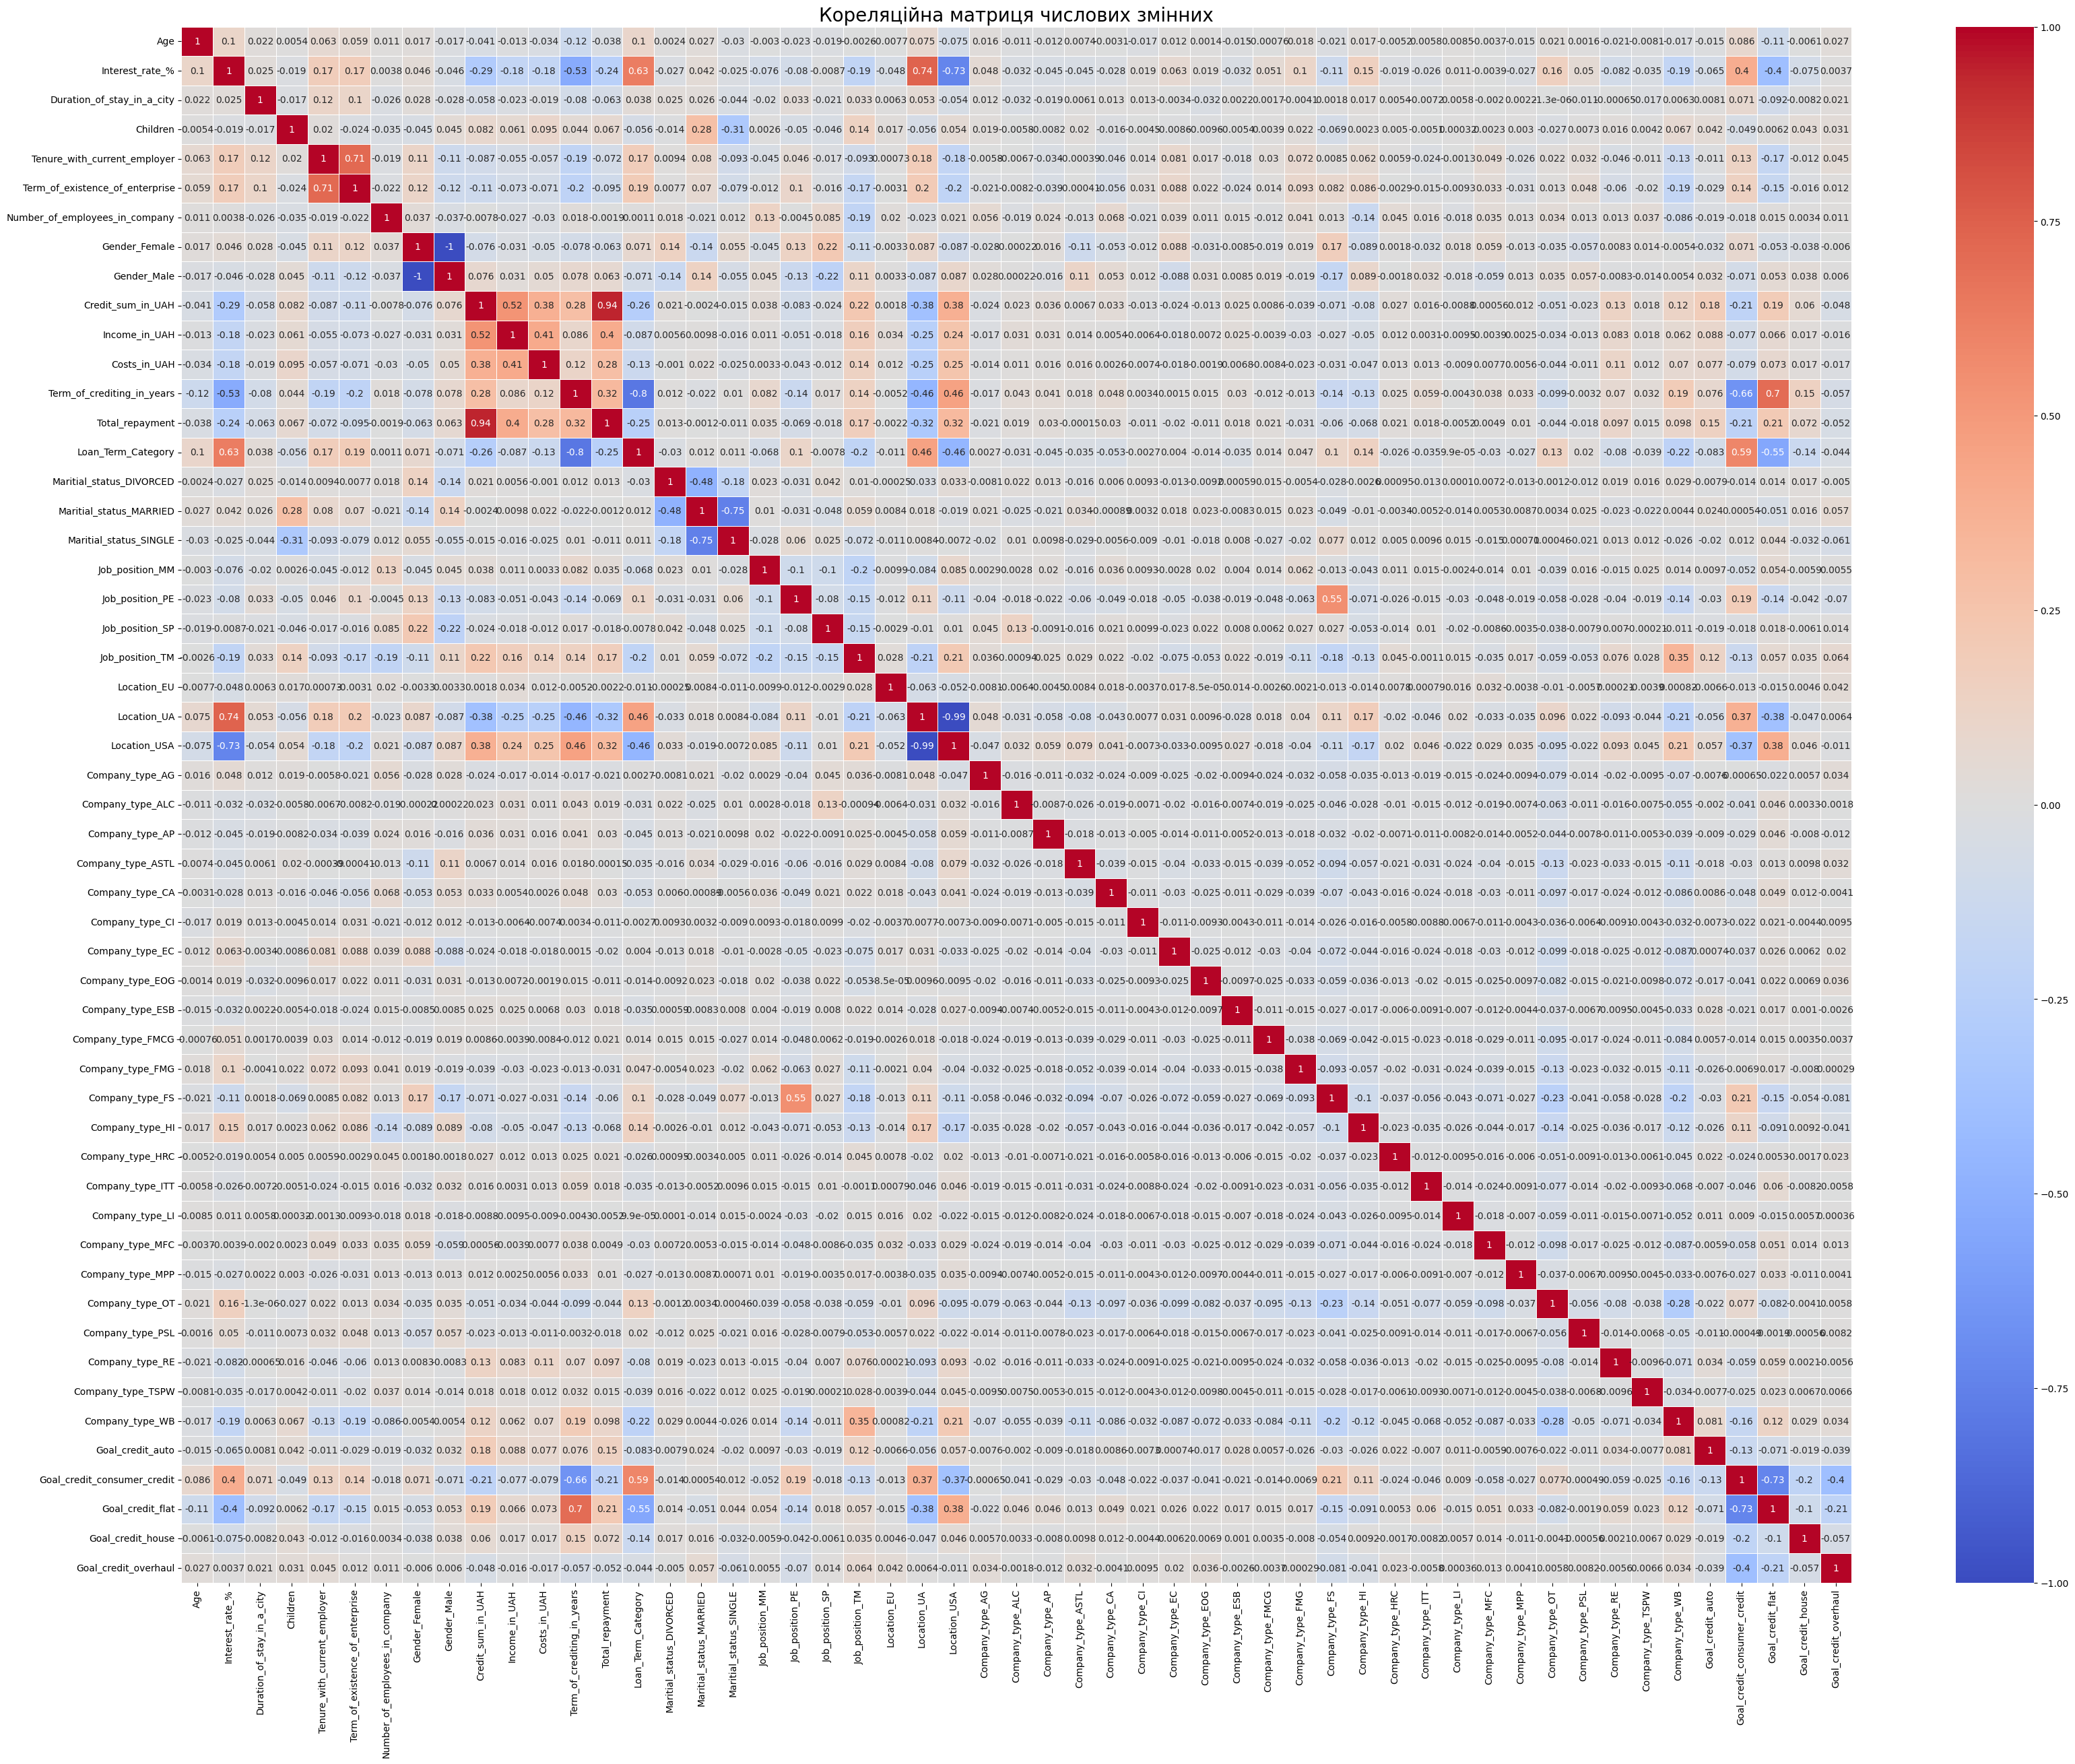

In [36]:
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'bool'])  
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(40, 30)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Кореляційна матриця числових змінних', fontsize=20)
plt.show()


In [37]:
columns_to_drop = ['Credit_sum_in_UAH', 'Job_position_MM', 'Job_position_TM', 'Job_position_SP', 
                   'Company_type_ITT', 'Company_type_MPP']

df.drop(columns=columns_to_drop, inplace=True)

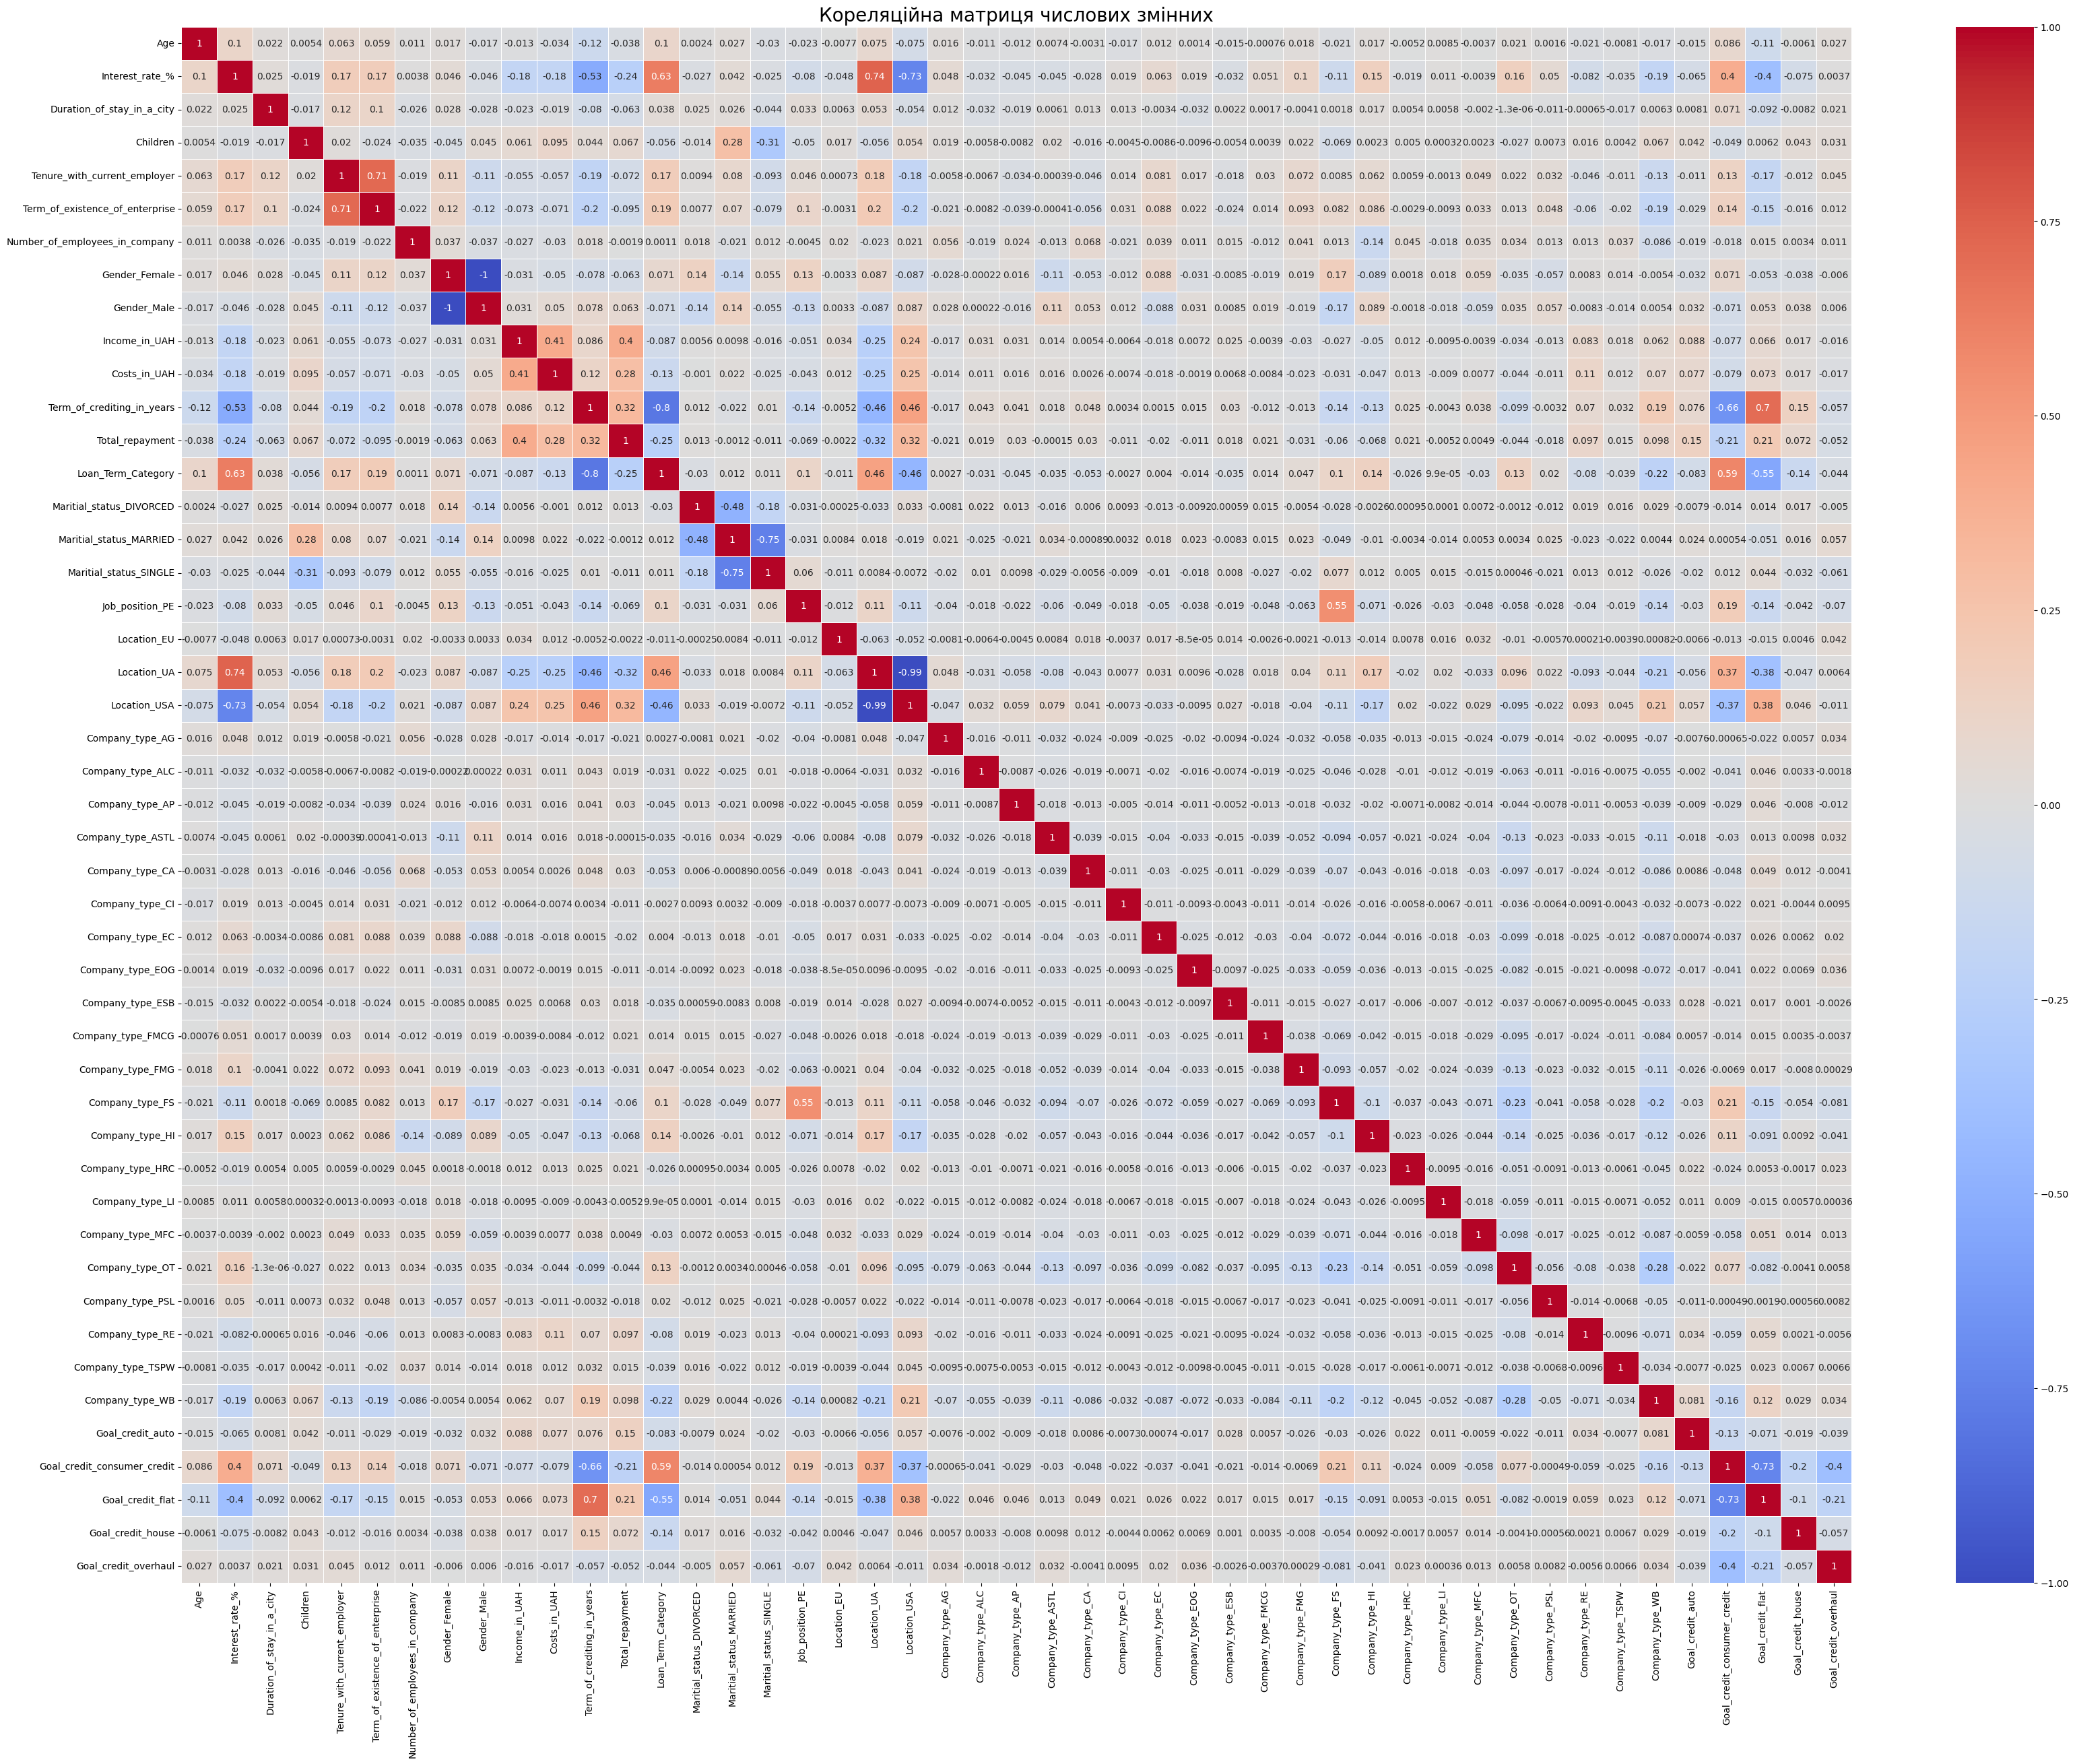

In [38]:
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'bool'])  # Вибираємо числові колонки
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Кореляційна матриця числових змінних', fontsize=20)
plt.show()

In [39]:
df.apply(lambda x: x.unique())

Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Interest_rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_city                 [42.0, 90.0, 1000.0, 18.0, 9.0, 4.5, 1.5]
Children                                                                [0, 1, 2, 3]
Tenure_with_current_employer         [42.0, 15.0, 1.5, 90.0, 1000.0, 4.5, 21.0, 9.0]
Term_of_existence_of_enterprise                                [42, 18, 6, 1000, 90]
Number_of_employees_in_company                                       [1, 3, 2, 0, 4]
Result                                                                   [good, bad]
Gender_Female                                                          [True, False]
Gender_Male                                                            [False, True]
Income_in_UAH                      [674, 28290, 1588, 199629, 637, 745, 3648, 393...
Costs_in_UAH                       [362, 14022, 767, 32800, 382, 

### Splitting into train and test data

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y = df['Result'].map({'good': 1, 'bad': 0})
X = df.drop(columns=['Result'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Function for model evaluation 

I am going to use Accuracy, Precision, Recall, F1 Score, AUC-ROC Score and Confusion Matrix

In [41]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC Score: {roc_auc:.4f}")
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [42]:
def predict_with_thresholds(model, X_test, y_test, thresholds=[0.95, 0.90, 0.85, 0.80]):
    probas = model.predict_proba(X_test)[:, 1]
    
    metrics_data = []

    for threshold in thresholds:
        y_pred_threshold = np.where(probas >= threshold, 1, 0)
        
        accuracy = accuracy_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold)
        recall = recall_score(y_test, y_pred_threshold)
        f1 = f1_score(y_test, y_pred_threshold)
        
        conf_matrix = confusion_matrix(y_test, y_pred_threshold)
        true_positives = conf_matrix[1, 1]
        true_negatives = conf_matrix[0, 0]
        false_positives = conf_matrix[0, 1]
        false_negatives = conf_matrix[1, 0]
        
        metrics_data.append({
            'Threshold': threshold,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'True Positives': true_positives,
            'True Negatives': true_negatives,
            'False Positives': false_positives,
            'False Negatives': false_negatives
        })

    metrics_df = pd.DataFrame(metrics_data)
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(metrics_df['Threshold'], metrics_df['Accuracy'], marker='o', label='Accuracy')
    plt.plot(metrics_df['Threshold'], metrics_df['Precision'], marker='o', label='Precision')
    plt.plot(metrics_df['Threshold'], metrics_df['Recall'], marker='o', label='Recall')
    plt.plot(metrics_df['Threshold'], metrics_df['F1 Score'], marker='o', label='F1 Score')
    
    plt.title('Metrics Change with Different Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    
    plt.plot(metrics_df['Threshold'], metrics_df['True Positives'], marker='o', label='True Positives', color='green')
    plt.plot(metrics_df['Threshold'], metrics_df['True Negatives'], marker='o', label='True Negatives', color='blue')
    plt.plot(metrics_df['Threshold'], metrics_df['False Positives'], marker='o', label='False Positives', color='red')
    plt.plot(metrics_df['Threshold'], metrics_df['False Negatives'], marker='o', label='False Negatives', color='orange')
    
    plt.title('Confusion Matrix Components Change with Different Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    return metrics_df

thresholds = [0.95, 0.90, 0.85, 0.80]

In [43]:
def calculate_errors(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    fp_train = conf_matrix_train[0, 1]  
    fn_train = conf_matrix_train[1, 0] 
    
    y_test_pred = model.predict(X_test)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)
    fp_test = conf_matrix_test[0, 1]
    fn_test = conf_matrix_test[1, 0]  
    
    print(f"Похибки 1-го роду (False Positives):")
    print(f"Навчальна вибірка: {fp_train}, Тестова вибірка: {fp_test}")
    print(f"Похибки 2-го роду (False Negatives):")
    print(f"Навчальна вибірка: {fn_train}, Тестова вибірка: {fn_test}")

def predict_default_probability(model, X_test):
    probabilities = model.predict_proba(X_test)[:, 1] 
    
    print("Ймовірності дефолту для перших 10 клієнтів:")
    print(probabilities[:10])

### CART (Дерево рішень)

CART Найкращі параметри: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
CART Найкраща точність на валідаційних даних: 0.9489


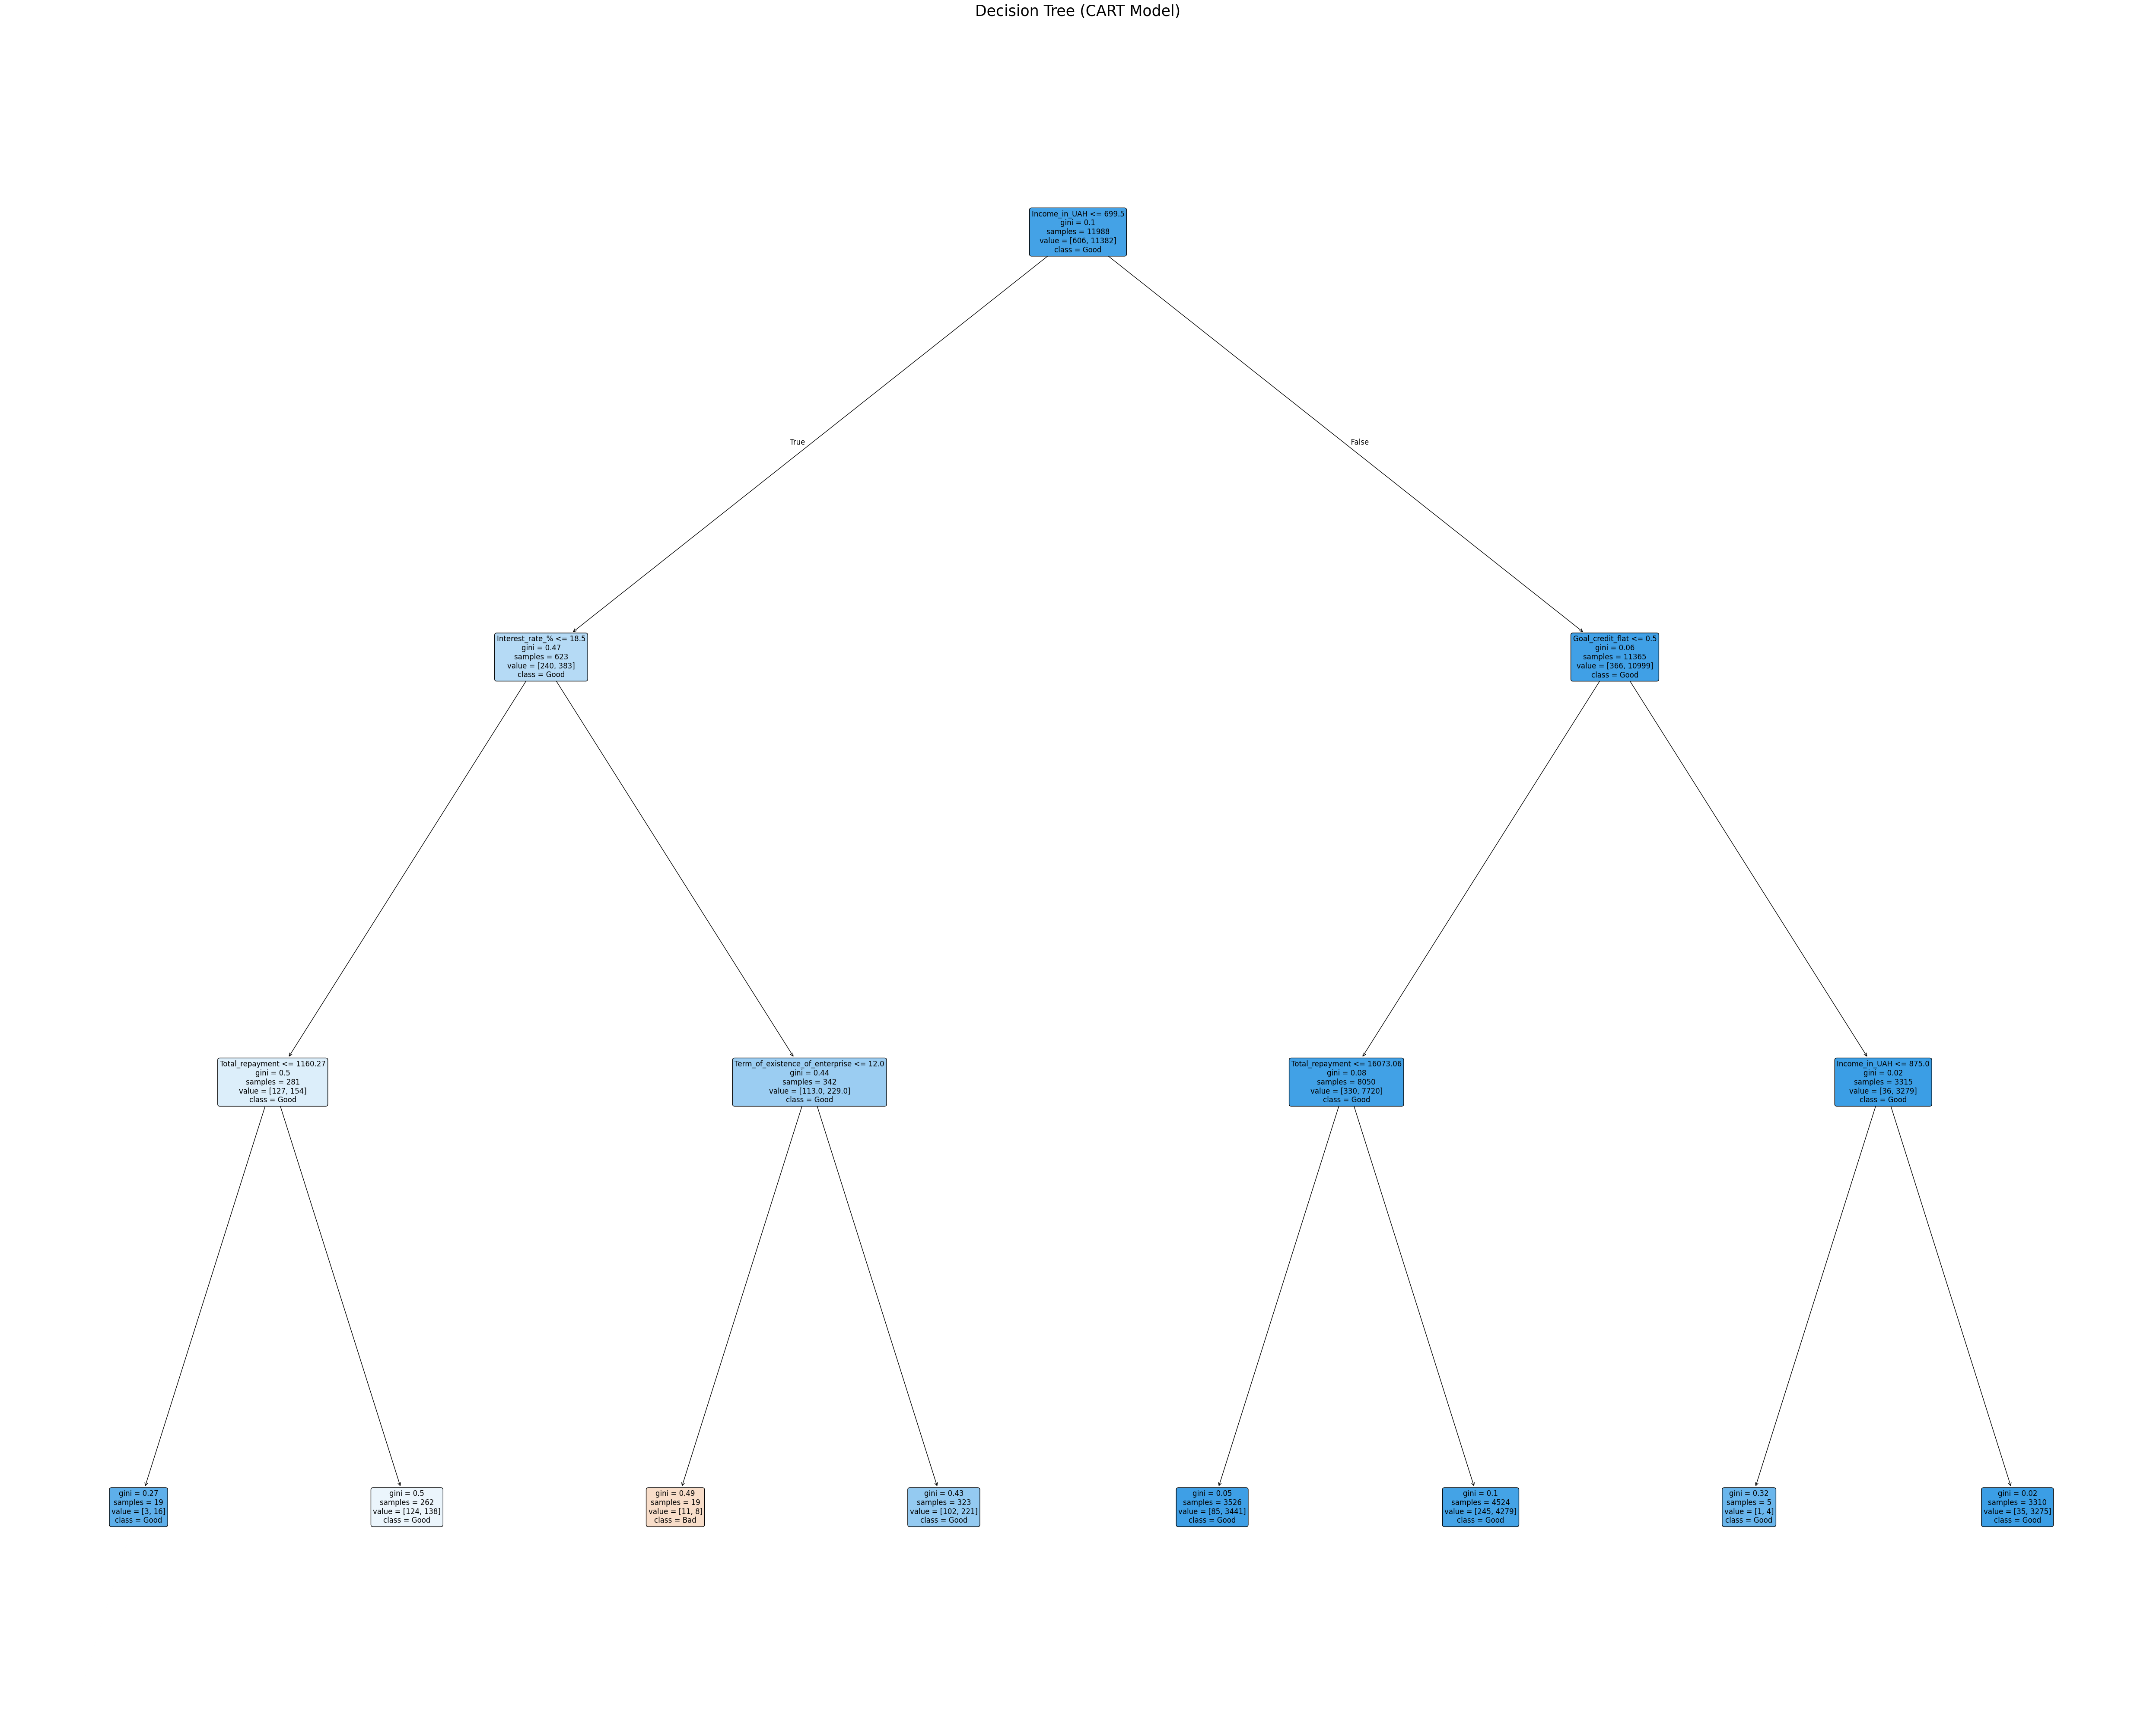

Accuracy: 0.9526
Precision: 0.9529
Recall: 0.9996
F1 Score: 0.9757
AUC-ROC Score: 0.5033


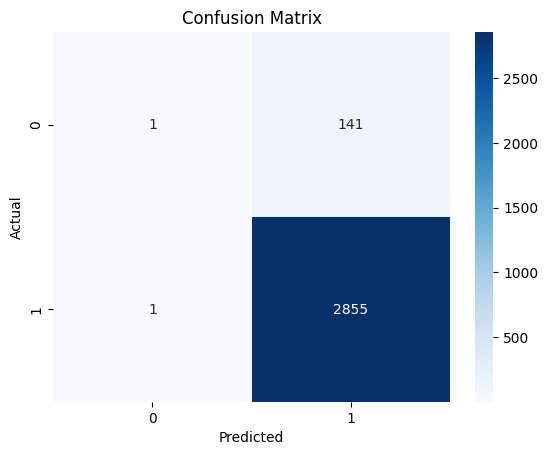

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV


# Параметри для пошуку по сітці для CART
param_grid_cart = {
    'max_depth': [3, 5, 7, 10, None],  # Різні варіанти глибини дерева
    'min_samples_split': [2, 10, 20],  # Мінімальна кількість зразків для поділу
    'min_samples_leaf': [1, 5, 10]  # Мінімальна кількість зразків у листі
}

# Створюємо CART модель
cart_model = DecisionTreeClassifier(random_state=42)

# Налаштовуємо Grid Search для CART
grid_search_cart = GridSearchCV(estimator=cart_model, param_grid=param_grid_cart, cv=5, scoring='accuracy')
grid_search_cart.fit(X_train, y_train)

# Виводимо найкращі параметри та точність
print(f'CART Найкращі параметри: {grid_search_cart.best_params_}')
print(f'CART Найкраща точність на валідаційних даних: {grid_search_cart.best_score_:.4f}')

# Прогнозування на тестових даних
y_pred_cart = grid_search_cart.best_estimator_.predict(X_test)

# Візуалізація дерева рішень
plt.figure(figsize=(50, 40))
plot_tree(grid_search_cart.best_estimator_, filled=True, feature_names=X_train.columns, class_names=['Bad', 'Good'], fontsize=12, proportion=False, rounded=True, precision=2)
plt.title("Decision Tree (CART Model)", fontsize=25)
plt.tight_layout()
plt.show()

# Оцінка моделі за допомогою твоєї функції
evaluate_model(y_test, y_pred_cart)

In [45]:
calculate_errors(grid_search_cart.best_estimator_, X_train, y_train, X_test, y_test)
predict_default_probability(grid_search_cart.best_estimator_, X_test)

Похибки 1-го роду (False Positives):
Навчальна вибірка: 595, Тестова вибірка: 141
Похибки 2-го роду (False Negatives):
Навчальна вибірка: 8, Тестова вибірка: 1
Ймовірності дефолту для перших 10 клієнтів:
[0.98942598 0.97589336 0.98942598 0.52671756 0.97589336 0.94584439
 0.94584439 0.97589336 0.98942598 0.97589336]


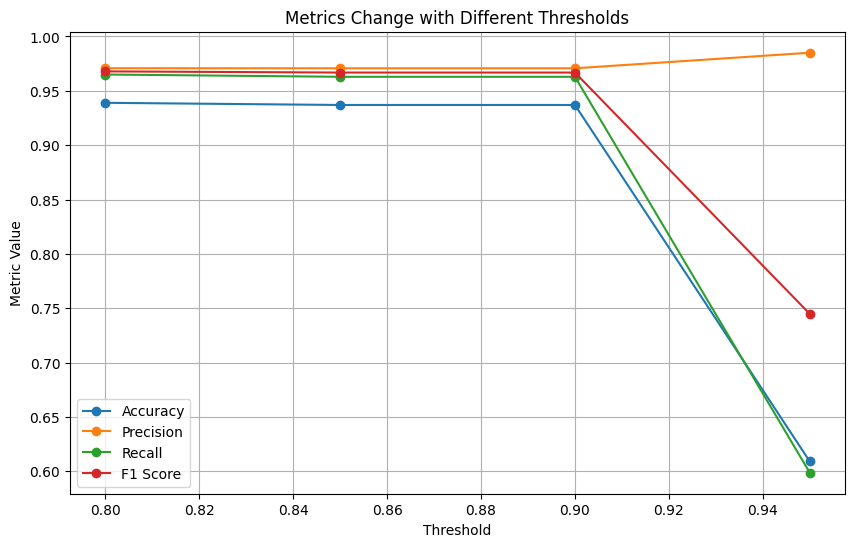

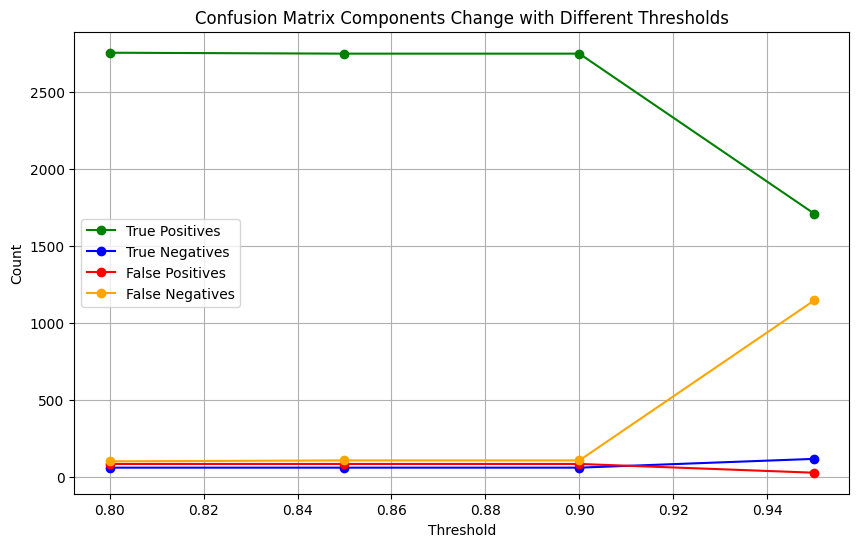

In [46]:
threshold_results_df = predict_with_thresholds(grid_search_cart.best_estimator_, X_test, y_test, thresholds)

### С4.5

C4.5 Найкращі параметри: {'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
C4.5 Найкраща точність на валідаційних даних: 0.9494


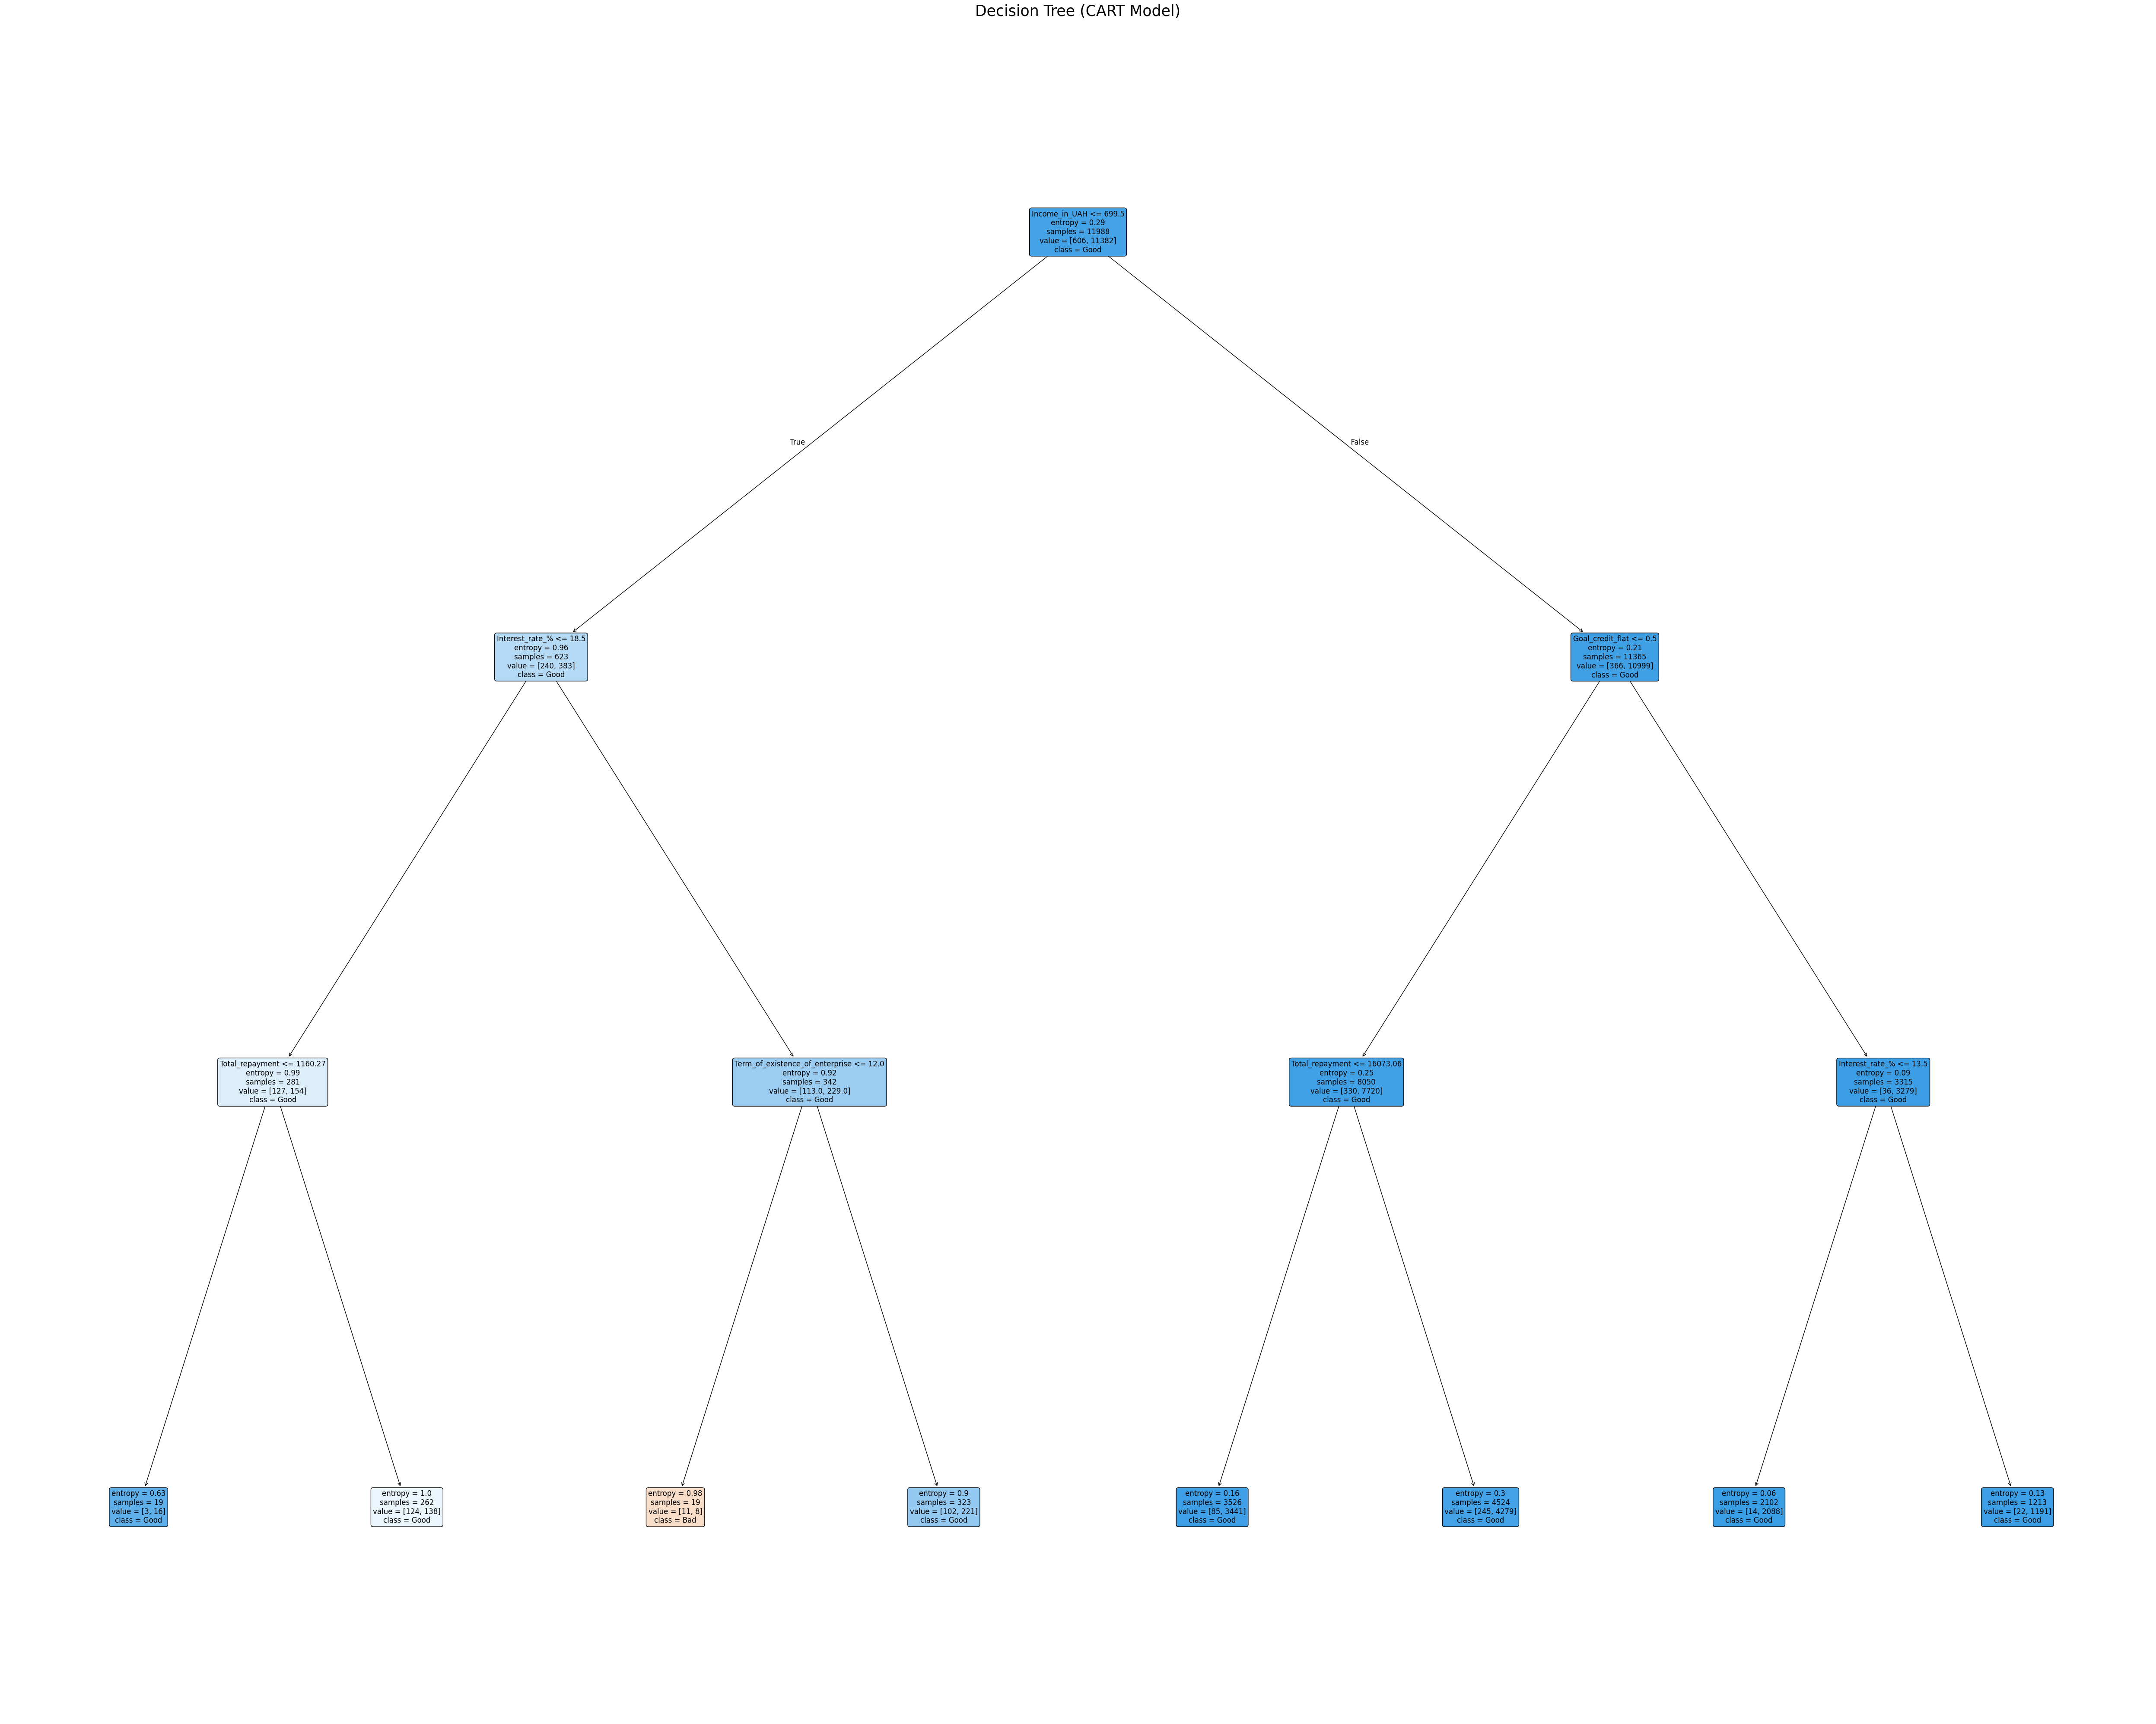

Accuracy: 0.9526
Precision: 0.9529
Recall: 0.9996
F1 Score: 0.9757
AUC-ROC Score: 0.5033


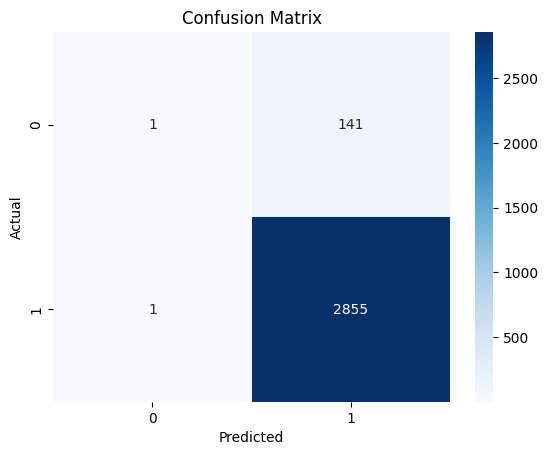

In [47]:
# Параметри для пошуку по сітці для C4.5
param_grid_c45 = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Створюємо C4.5 модель
c45_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Налаштовуємо Grid Search для C4.5
grid_search_c45 = GridSearchCV(estimator=c45_model, param_grid=param_grid_c45, cv=5, scoring='accuracy')
grid_search_c45.fit(X_train, y_train)

# Виводимо найкращі параметри та точність
print(f'C4.5 Найкращі параметри: {grid_search_c45.best_params_}')
print(f'C4.5 Найкраща точність на валідаційних даних: {grid_search_c45.best_score_:.4f}')

# Прогнозування на тестових даних
y_pred_c45 = grid_search_c45.best_estimator_.predict(X_test)

# Візуалізація дерева рішень
plt.figure(figsize=(50, 40))
plot_tree(grid_search_c45.best_estimator_, filled=True, feature_names=X_train.columns, class_names=['Bad', 'Good'], fontsize=12, proportion=False, rounded=True, precision=2)
plt.title("Decision Tree (CART Model)", fontsize=25)
plt.tight_layout()
plt.show()

# Оцінка моделі за допомогою твоєї функції
evaluate_model(y_test, y_pred_c45)


In [48]:
calculate_errors(grid_search_c45.best_estimator_, X_train, y_train, X_test, y_test)
predict_default_probability(grid_search_c45.best_estimator_, X_test)

Похибки 1-го роду (False Positives):
Навчальна вибірка: 595, Тестова вибірка: 141
Похибки 2-го роду (False Negatives):
Навчальна вибірка: 8, Тестова вибірка: 1
Ймовірності дефолту для перших 10 клієнтів:
[0.99333968 0.97589336 0.99333968 0.52671756 0.97589336 0.94584439
 0.94584439 0.97589336 0.99333968 0.97589336]


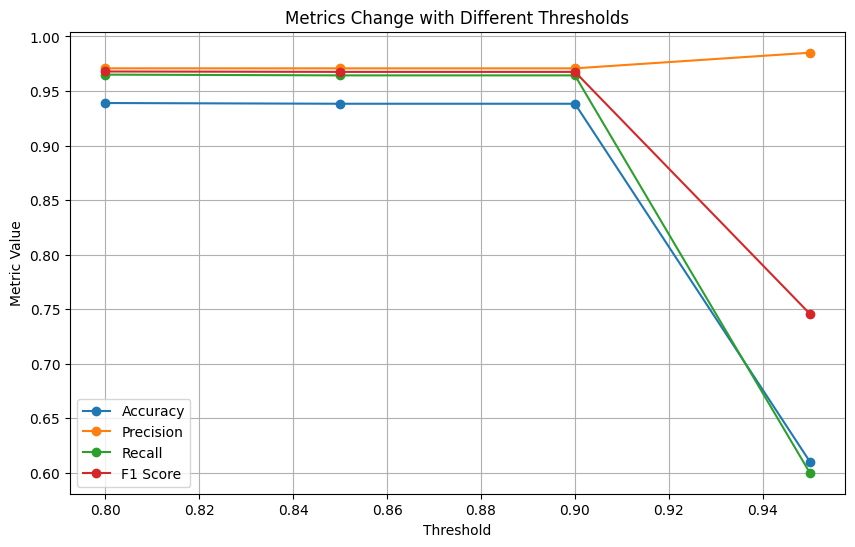

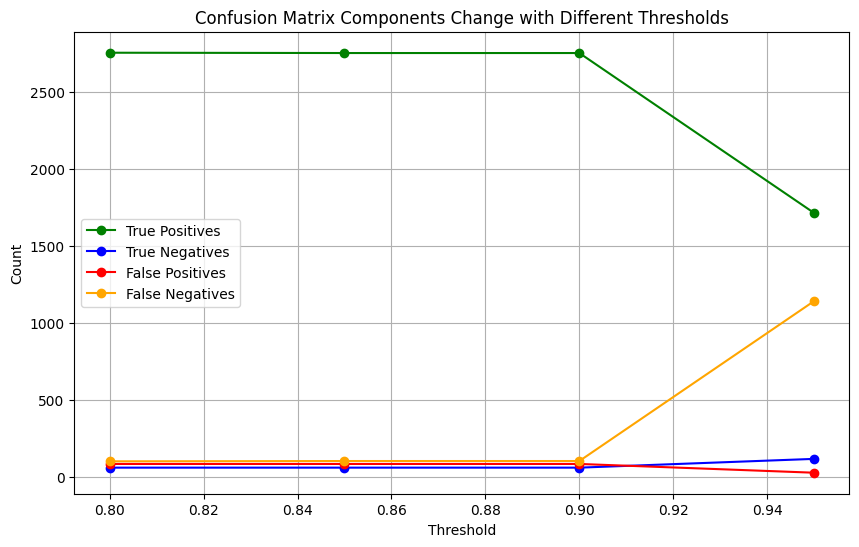

In [49]:
threshold_results_с45 = predict_with_thresholds(grid_search_c45.best_estimator_, X_test, y_test, thresholds)

### LightBGM

The numeric featuers should be coded into categorical for this method

In [50]:
dt = pd.read_csv('DataBase.csv')

dt.head()

Gender  Age  Сredit_sum Currency  Term_of_crediting_in day  \
0  Female   27         850      UAH                       360   
1    Male   35         400      USD                       240   
2    Male   43        2750      UAH                       240   
3    Male   43       15000      USD                      1800   
4    Male   28        2500      UAH                      1080   

   Interest rate_% Duration_of_stay_in_a_sity  Maritial_status Children  \
0               18                       24_60          SINGLE       c0   
1               12                       24_60          SINGLE       c0   
2               14                       24_60         MARRIED       c1   
3               15                      60_120         MARRIED       c1   
4               18                      60_120          SINGLE       c0   

  Job_position Tenure_with_current_employer Term_of_existence_of_enterprise  \
0           PE                        24_60                           24_60   
1           AS                        24_60                           24_60   
2           AS                        12_18                           12_24   
3           TM                        24_60                           24_60   
4           PE                          0_3                            0_12   

  Company_type Number_of_employees_in_kompany   Income_customer  \
0           FS                        100_9999              674   
1          FMG                          51_100              690   
2           OT                           31_50             1588   
3           OT                             0_5             4869   
4           FS                        100_9999              637   

   Costs_customer      goal_credit Result  
0             362  consumer_credit   good  
1             342  consumer_credit    bad  
2             767  consumer_credit   good  
3             800  consumer_credit    bad  
4             382  consumer_credit   good

In [51]:
dt.columns = dt.columns.str.strip()

dt.rename(columns={'Term_of_crediting_in day': 'Term_of_crediting_in_days',
                   'Interest rate_%': 'Interest_rate_%',
                   'Duration_of_stay_in_a_sity': 'Duration_of_stay_in_a_city',
                   'Number_of_employees_in_kompany': 'Number_of_employees_in_company',
                   'goal_credit': 'Goal_credit'}, inplace=True)

In [52]:
dt.apply(lambda x: x.unique())

Gender                                                                [Female, Male]
Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Сredit_sum                         [850, 400, 2750, 15000, 2500, 2215, 54600, 200...
Currency                                              [UAH, USD, EUR, 0,  USD,  UAH]
Term_of_crediting_in_days          [360, 240, 1800, 1080, 90, 2520, 60, 720, 1080...
Interest_rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_city          [24_60, 60_120, 120_9999, 12_24, 6_12, 3_6, 0_3]
Maritial_status                           [SINGLE, MARRIED, DIVORCED, CIVILMARRIAGE]
Children                                                            [c0, c1, c2, c3]
Job_position                                                    [PE, AS, TM, SP, MM]
Tenure_with_current_employer       [24_60, 12_18, 0_3, 60_120, 120_9999, 3_6, 18_...
Term_of_existence_of_enterprise               [24_60, 12_24, 0_12

In [53]:
dt['Currency'] = dt['Currency'].str.strip()
dt['Currency'].replace('0', np.nan, inplace=True)

/var/folders/vg/lfx3769n7_560g_6160v_23m0000gn/T/ipykernel_68023/4064075924.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dt['Currency'].replace('0', np.nan, inplace=True)


In [54]:
dt.dropna(subset=['Currency'], inplace=True)
dt['Currency'].unique()

array(['UAH', 'USD', 'EUR'], dtype=object)

In [55]:
exchange_rates = {
    'UAH': 1,   
    'USD': 41,  
    'EUR': 46   
}

dt['Credit_sum_in_UAH'] = dt['Сredit_sum'] * dt['Currency'].map(exchange_rates)
dt['Income_in_UAH'] = dt['Income_customer'] * dt['Currency'].map(exchange_rates)
dt['Costs_in_UAH'] = dt['Costs_customer'] * dt['Currency'].map(exchange_rates)

dt[['Сredit_sum', 'Income_customer', 'Costs_customer', 'Currency', 'Credit_sum_in_UAH', 'Income_in_UAH', 'Costs_in_UAH']].head()

Сredit_sum  Income_customer  Costs_customer Currency  Credit_sum_in_UAH  \
0         850              674             362      UAH                850   
1         400              690             342      USD              16400   
2        2750             1588             767      UAH               2750   
3       15000             4869             800      USD             615000   
4        2500              637             382      UAH               2500   

   Income_in_UAH  Costs_in_UAH  
0            674           362  
1          28290         14022  
2           1588           767  
3         199629         32800  
4            637           382

In [56]:
dt.drop(columns=['Сredit_sum', 'Income_customer', 'Costs_customer'], inplace=True)

In [57]:
dt = dt[dt['Term_of_crediting_in_days'] <= 10980]

dt[['Term_of_crediting_in_days']].describe()

Term_of_crediting_in_days
count                  14,986.00
mean                    2,015.65
std                     1,627.77
min                        30.00
25%                       720.00
50%                     1,800.00
75%                     2,520.00
max                    10,800.00

In [58]:
dt['Term_of_crediting_in_years'] = dt['Term_of_crediting_in_days']/365
dt.drop(columns=['Term_of_crediting_in_days'], inplace=True)

dt[['Term_of_crediting_in_years']].head()

Term_of_crediting_in_years
0                        0.99
1                        0.66
2                        0.66
3                        4.93
4                        2.96

In [59]:
dt['Term_of_crediting_in_years'].min(), dt['Term_of_crediting_in_years'].max()

(0.0821917808219178, 29.589041095890412)

In [60]:
dt['Total_repayment'] = dt['Credit_sum_in_UAH'] * (1 + (dt['Interest_rate_%'] / 100) * dt['Term_of_crediting_in_years'])
pd.options.display.float_format = '{:,.2f}'.format
dt[['Credit_sum_in_UAH', 'Interest_rate_%', 'Term_of_crediting_in_years', 'Total_repayment']].head()

Credit_sum_in_UAH  Interest_rate_%  Term_of_crediting_in_years  \
0                850               18                        0.99   
1              16400               12                        0.66   
2               2750               14                        0.66   
3             615000               15                        4.93   
4               2500               18                        2.96   

   Total_repayment  
0         1,000.90  
1        17,694.03  
2         3,003.15  
3     1,069,931.51  
4         3,831.51

In [61]:
bins = [0, 1, 5, 30]
labels = ['Short-Term', 'Medium-Term', 'Long-Term']  
dt['Loan_Term_Category'] = pd.cut(df['Term_of_crediting_in_years'], bins=bins, labels=labels, right=False)
dt[['Term_of_crediting_in_years', 'Loan_Term_Category']].head()

Term_of_crediting_in_years Loan_Term_Category
0                        0.99         Short-Term
1                        0.66         Short-Term
2                        0.66         Short-Term
3                        4.93        Medium-Term
4                        2.96        Medium-Term

In [62]:
dt.apply(lambda x: x.unique())

Gender                                                                [Female, Male]
Age                                [27, 35, 43, 28, 29, 38, 33, 37, 32, 47, 41, 4...
Currency                                                             [UAH, USD, EUR]
Interest_rate_%                    [18, 12, 14, 15, 20, 19, 22, 26, 16, 17, 23, 1...
Duration_of_stay_in_a_city          [24_60, 60_120, 120_9999, 12_24, 6_12, 3_6, 0_3]
Maritial_status                           [SINGLE, MARRIED, DIVORCED, CIVILMARRIAGE]
Children                                                            [c0, c1, c2, c3]
Job_position                                                    [PE, AS, TM, SP, MM]
Tenure_with_current_employer       [24_60, 12_18, 0_3, 60_120, 120_9999, 3_6, 18_...
Term_of_existence_of_enterprise               [24_60, 12_24, 0_12, 120_9999, 60_120]
Company_type                       [FS, FMG, OT, WB, EC, HI, MPP, ASTL, EOG, ITT,...
Number_of_employees_in_company                  [100_9999, 51_100

In [63]:
dt['Age'] = pd.cut(dt['Age'], 
                   bins=[dt['Age'].min(), 30, 50, dt['Age'].max() + 1], 
                   labels=["young", "middle-aged", "older"], 
                   include_lowest=True)

In [64]:
dt['Interest_rate_%'] = pd.cut(dt['Interest_rate_%'], bins=3, labels=["low", "medium", "high"])

In [65]:
columns_to_analyze = ['Credit_sum_in_UAH', 'Income_in_UAH', 'Costs_in_UAH', 'Term_of_crediting_in_years', 'Total_repayment']
min_max_values = dt[columns_to_analyze].agg(['min', 'max'])

min_max_values

Credit_sum_in_UAH  Income_in_UAH  Costs_in_UAH  \
min                336            213             0   
max           86100000       43478409       8212259   

     Term_of_crediting_in_years  Total_repayment  
min                        0.08           347.05  
max                       29.59   306,893,424.66

In [66]:
# Оновлюємо код для уникнення NaN

# Дискретизація змінних на категорії, включаючи всі можливі значення
dt['Credit_sum_in_UAH'] = pd.cut(dt['Credit_sum_in_UAH'], 
                                 bins=[dt['Credit_sum_in_UAH'].min(), 100000, 1000000, dt['Credit_sum_in_UAH'].max()], 
                                 labels=["low", "medium", "high"], include_lowest=True)

dt['Income_in_UAH'] = pd.cut(dt['Income_in_UAH'], 
                             bins=[dt['Income_in_UAH'].min(), 100000, 1000000, dt['Income_in_UAH'].max()], 
                             labels=["low", "medium", "high"], include_lowest=True)

dt['Costs_in_UAH'] = pd.cut(dt['Costs_in_UAH'], 
                            bins=[dt['Costs_in_UAH'].min(), 50000, 500000, dt['Costs_in_UAH'].max()], 
                            labels=["low", "medium", "high"], include_lowest=True)

dt['Term_of_crediting_in_years'] = pd.cut(dt['Term_of_crediting_in_years'], 
                                          bins=[dt['Term_of_crediting_in_years'].min(), 5, 15, dt['Term_of_crediting_in_years'].max()], 
                                          labels=["short-term", "medium-term", "long-term"], include_lowest=True)

dt['Total_repayment'] = pd.cut(dt['Total_repayment'], 
                               bins=[dt['Total_repayment'].min(), 100000, 1000000, dt['Total_repayment'].max()], 
                               labels=["low", "medium", "high"], include_lowest=True)


In [67]:
dt.apply(lambda x: x.unique())

Gender                                                                [Female, Male]
Age                                ['young', 'middle-aged', 'older']
Categories (...
Currency                                                             [UAH, USD, EUR]
Interest_rate_%                    ['medium', 'high', 'low']
Categories (3, objec...
Duration_of_stay_in_a_city          [24_60, 60_120, 120_9999, 12_24, 6_12, 3_6, 0_3]
Maritial_status                           [SINGLE, MARRIED, DIVORCED, CIVILMARRIAGE]
Children                                                            [c0, c1, c2, c3]
Job_position                                                    [PE, AS, TM, SP, MM]
Tenure_with_current_employer       [24_60, 12_18, 0_3, 60_120, 120_9999, 3_6, 18_...
Term_of_existence_of_enterprise               [24_60, 12_24, 0_12, 120_9999, 60_120]
Company_type                       [FS, FMG, OT, WB, EC, HI, MPP, ASTL, EOG, ITT,...
Number_of_employees_in_company                  [100_9999, 51_100

Gender                             category
Age                                category
Currency                           category
Interest_rate_%                    category
Duration_of_stay_in_a_city         category
Maritial_status                    category
Children                           category
Job_position                       category
Tenure_with_current_employer       category
Term_of_existence_of_enterprise    category
Company_type                       category
Number_of_employees_in_company     category
Goal_credit                        category
Credit_sum_in_UAH                  category
Income_in_UAH                      category
Costs_in_UAH                       category
Term_of_crediting_in_years         category
Total_repayment                    category
Loan_Term_Category                 category
dtype: object
[LightGBM] [Info] Number of positive: 11382, number of negative: 606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

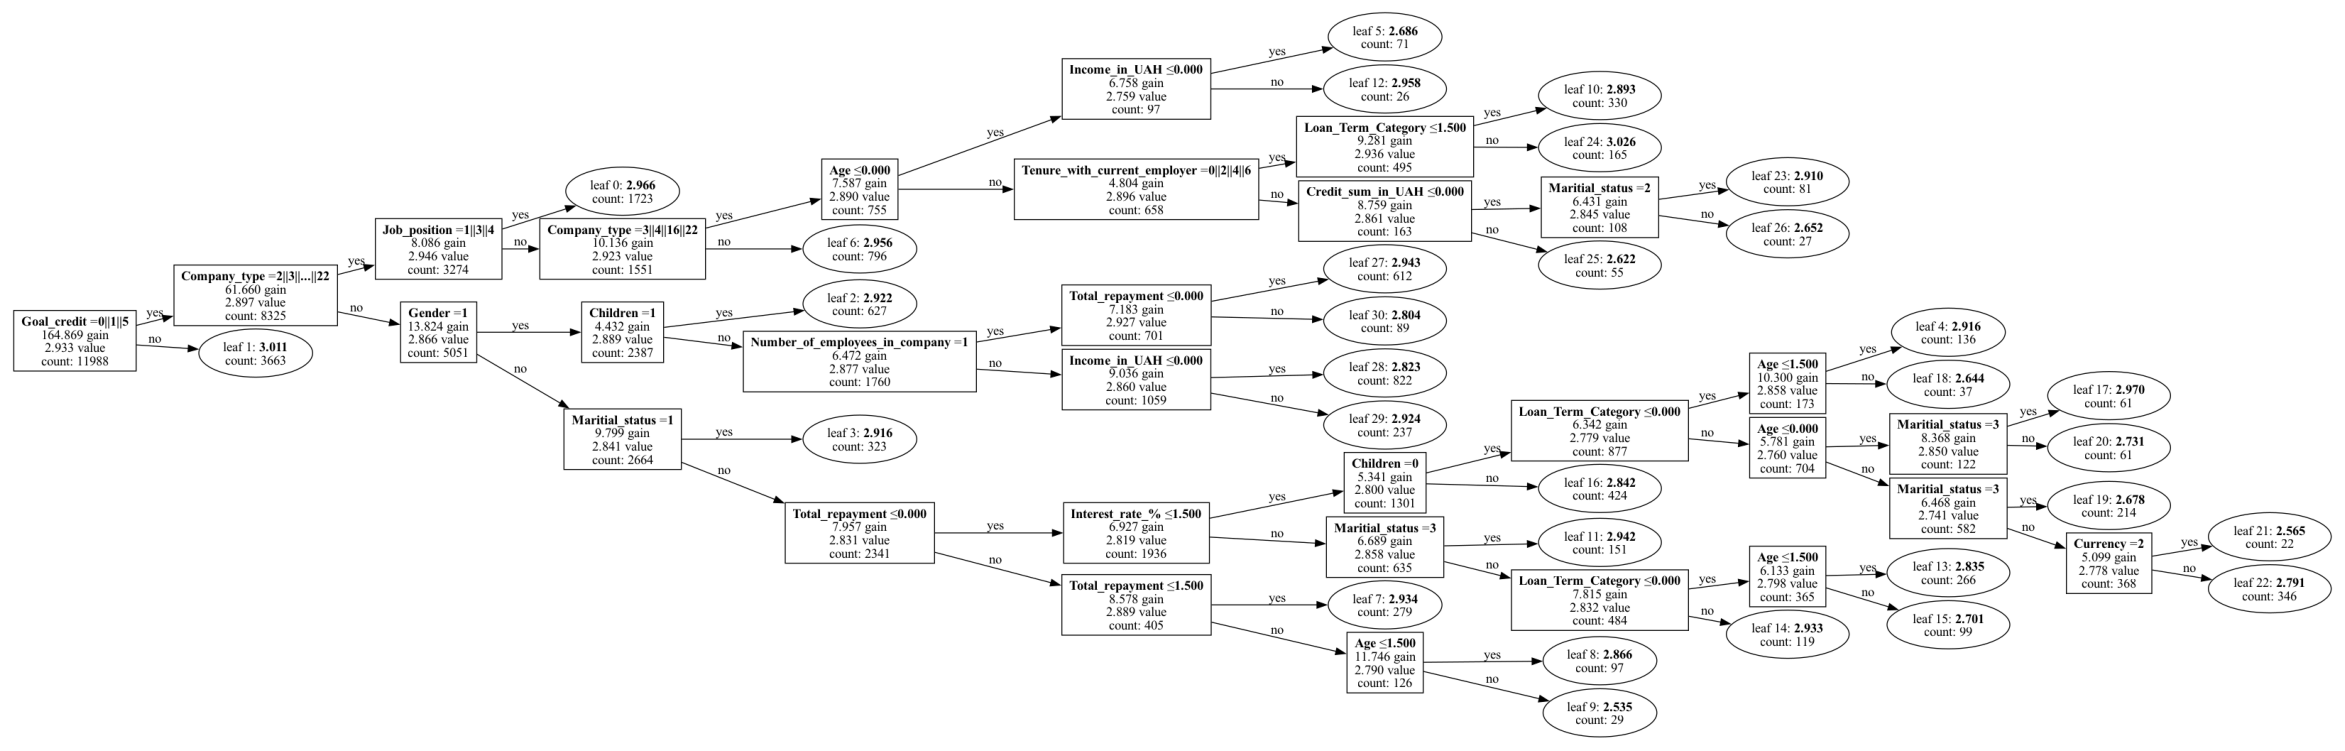

In [68]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Перетворимо цільову змінну 'Result' на числові значення
dt['Result'] = dt['Result'].map({'good': 1, 'bad': 0})

# Виділяємо ознаки (X) і цільову змінну (y)
X = dt.drop(columns=['Result'])  # 'Result' - це стовпець з цільовою змінною
y = dt['Result']

# Розділяємо дані на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Перелік категоріальних ознак (їх назви)
categorical_features = ['Gender', 'Currency', 'Duration_of_stay_in_a_city', 'Maritial_status', 
                        'Children', 'Job_position', 'Tenure_with_current_employer', 
                        'Term_of_existence_of_enterprise', 'Company_type', 
                        'Number_of_employees_in_company', 'Goal_credit']

# Перетворимо всі категоріальні змінні на тип 'category'
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Переконаймося, що всі ознаки правильно перетворені
print(X_train.dtypes)

# Створюємо LightGBM датасет для тренувальних даних
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)

# Налаштування моделі LightGBM
params = {
    'objective': 'binary',  # Оскільки це задача класифікації з двома класами
    'metric': 'binary_logloss',  # Можна також використовувати 'accuracy'
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'learning_rate': 0.1,
    'num_leaves': 31,  # Кількість листків у дереві
    'max_depth': -1,  # Без обмеження глибини
    'feature_pre_filter': False  # Не фільтрувати ознаки попередньо
}

# Навчання моделі LightGBM
lgb_model = lgb.train(params, train_data)

# Прогнозуємо на тестових даних
y_pred_proba = lgb_model.predict(X_test)

# Перетворюємо ймовірності в класи (порогове значення 0.5)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba]

# Оцінюємо точність моделі
accuracy = accuracy_score(y_test, y_pred)
print(f'Точність моделі LightGBM: {accuracy:.4f}')

ax = lgb.plot_tree(lgb_model, tree_index=0, figsize=(30, 20), show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])

plt.show()
